In [1]:
import glob
import sahi
import os
import json

import numpy as np

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
#from ultralytics import YOLO

import seaborn as sns

from sklearn.metrics import auc

In [10]:
%pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.18ubuntu0.18.04.1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sahi.utils.yolov8 import (

download_yolov8m_model
)



from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

## Auxiliary functions

In [3]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [4]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [11]:
%pip install --upgrade certifi

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 158 kB 3.3 MB/s            
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.9.24
    Uninstalling certifi-2022.9.24:
      Successfully uninstalled certifi-2022.9.24
Note: you may need to restart the kernel to use updated packages.


In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [10]:
predictions = get_prediction(read_image("people_test_images/frame1.jpg"), detection_model)

In [7]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [8]:
image = cv2.imread("datasets/images/people_frames_10.jpg")
height, width = image.shape[:2]

In [6]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [7]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [8]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

### Unite all in one function

In [9]:
def compute_AP50_for_image(gt_path, predictions, image_path):
    '''
    compute AP50 for one image
    :param gt_path: path to GT labels in the file
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=='0'] #select only people (class 0)
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(1000))
    i=0
    for result in predictions:
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = image_path
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            ious=[]
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0
            i+=1
        else:
            continue

    num_gt = len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt


    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



### Get usual predictions

In [13]:
predictions = get_prediction(read_image("datasets/images/people_frames_10.jpg"), detection_model)
#results in form tlwh
results = predictions.to_coco_annotations()

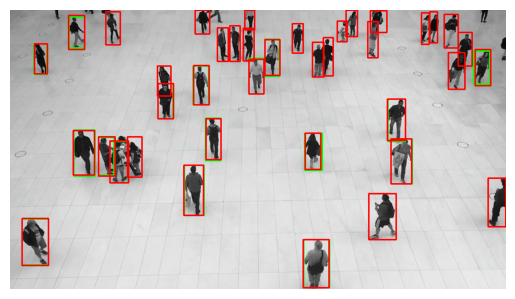

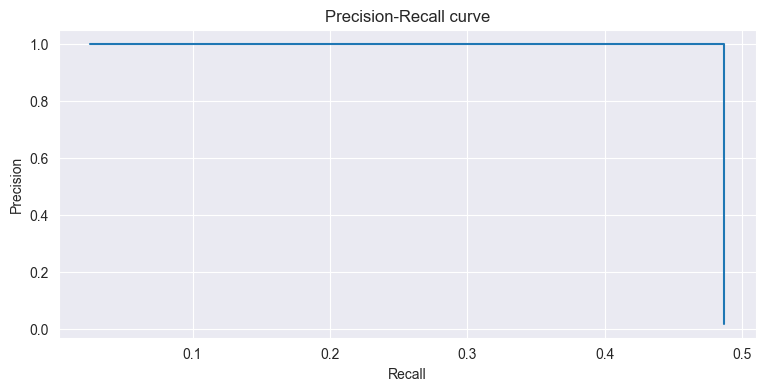

AP50 = 0.4615


In [14]:
compute_AP50_for_image("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

## Get sliced predictions

In [17]:
result = get_sliced_prediction(
    "people_test_images/frame1.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.8,
    overlap_width_ratio = 0.8
)

Performing prediction on 105 number of slices.


KeyboardInterrupt: 

In [16]:
results = result.to_coco_annotations()

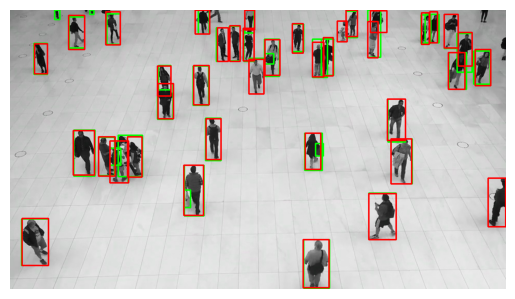

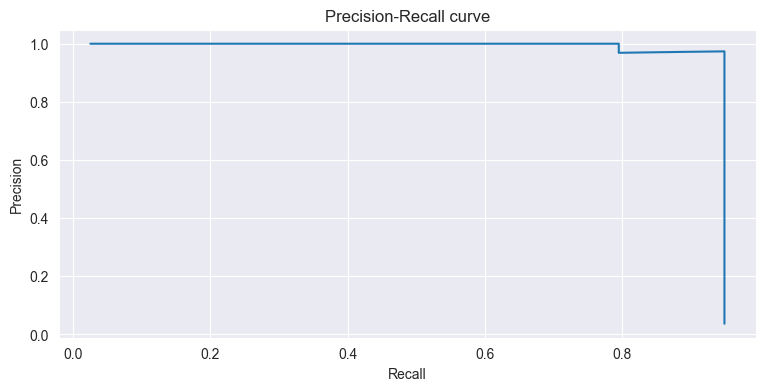

AP50 = 0.9187


In [17]:
compute_AP50_for_image("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

In [18]:
!wget http://images.cocodataset.org/zips/val2014.zip -O coco_val2014.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -O coco_ann2014.zip

UsageError: Cell magic `%%wget` not found.


In [18]:
# Opening JSON file
f = open('coco-2017/validation/new_labels.json')

# returns JSON object as
# a dictionary
data = json.load(f)

In [19]:
data

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01',
  'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
    'id': 1,
    'name': 'Attribution-NonCommercial-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
    'id': 2,
    'name': 'Attribution-NonCommercial License'},
   {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
    'id': 3,
    'name': 'Attribution-NonCommercial-NoDerivs License'},
   {'url': 'http://creativecommons.org/licenses/by/2.0/',
    'id': 4,
    'name': 'Attribution License'},
   {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
    'id': 5,
    'name': 'Attribution-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
    'id': 6,
    'name': 'Attribution-NoDerivs License'},
   {'url': 'http://flickr.com/commons/usage/',
    'id': 7

In [8]:
def change_annotations_to_yolo(json_file, out_file):
    '''
    changes annotations from coco to yolo format: id starting from 0 to ....
    :param json_file: old file
    :param out_file: output file with new categories
    '''

    # Opening JSON file
    f = open(json_file)

    # returns JSON object as a dictionary
    data = json.load(f)

    annotations = data['annotations']
    for annotation in annotations:
        annotation['category_id']-=1

    data['annotations'] = annotations

    categories = data['categories']
    for category in categories:
        category['id']-=1

    data['categories'] = categories

    try:
        info_categories = data['info']['categories']
        for category in info_categories:
            category['id']-=1
        data['info']['categories'] = info_categories
    except:
        pass


    json_object = json.dumps(data, indent=4)

    # Writing to sample.json
    with open(out_file, "w") as outfile:
        outfile.write(json_object)



In [208]:
change_annotations_to_yolo("coco-2017/validation/labels.json", "coco-2017/validation/new_labels.json")

In [8]:
def convert_labels(x1, y1, x2, y2):
    '''
    Definition: Parses label files to extract label and bounding box
    coordinates. Converts (x1, y1, x1, y2) KITTI format to
    (x, y, width, height) normalized YOLO format.
    '''
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin

    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)

    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin

    return (x,y,w,h) #x_c, y_c, w, h

### Convert COCO annotations to YOLO format (x_c, y_c, width, height)/(width, height)

In [20]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [74]:
for i in range(len(training_data['annotations'])):
    image_id = str(training_data['annotations'][i]['image_id'])
    category_id = str(training_data['annotations'][i]['category_id'])
    bbox = training_data['annotations'][i]['bbox']
    # for image in training_data['images']:
    #     if str(image['id'])==str(image_id).strip():
    #         width = image['width']
    #         height = image['height']
    #         break

    kitti_bbox = [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]] #tlbr
    yolo_bbox = convert_labels(kitti_bbox[0], kitti_bbox[1], kitti_bbox[2], kitti_bbox[3])
    training_data['annotations'][i]['bbox'] = yolo_bbox

In [75]:
json_object = json.dumps(training_data, indent=4)

    # Writing to sample.json
with open("coco-2017/validation/new_labels.json", "w") as outfile:
    outfile.write(json_object)

In [1]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [2]:
extract_val_path = "./coco_val2014"
extract_ann_path="./coco_ann2014"

extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

### Download part of COCO dataset only with people

In [10]:
import fiftyone as fo
import fiftyone.zoo as foz

ModuleNotFoundError: No module named 'fiftyone'

In [106]:
# To download the COCO dataset for only the "person" class
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    max_samples=200,
    only_matching=True
)

09/01/2023 16:45:03 - INFO - fiftyone.zoo.datasets -   Downloading split 'validation' to 'C:\Users\user\fiftyone\coco-2017\validation' if necessary


09/01/2023 16:45:03 - INFO - fiftyone.utils.coco -   Downloading annotations to 'C:\Users\user\fiftyone\coco-2017\tmp-download\annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


09/01/2023 16:46:02 - INFO - eta.core.utils -    100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:02 - INFO - fiftyone.utils.coco -   Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:09 - INFO - fiftyone.utils.coco -   Downloading 200 images


 100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


09/01/2023 16:46:21 - INFO - eta.core.utils -    100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


09/01/2023 16:46:21 - INFO - fiftyone.utils.coco -   Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Functions to predict and to evaluate

In [ ]:
# !sahi predict --source coco-2017/validation/data --dataset_json_path coco-2017/validation/new_labels.json --model_type yolov8 --model_path yolov8m.pt --slice_height 256 --slice_width 256 --overlap_height_ratio 0.2 --overlap_width_ratio 0.2 --model_confidence_threshold 0.25
#
#
# !sahi coco evaluate --dataset_json_path coco-2017/validation/new_labels.json --result_json_path runs/predict/exp_512_08/result.json --out_dir output/results_512_08

### SAHI results for different slice and overlap

In [30]:
sahi_results = pd.DataFrame(columns=["slice", "overlap", "mAP50", "mAP50s", "mAP50m", "mAP50l"], index=range(6))

In [31]:
for i, dir in enumerate(os.listdir("output")):
    parts = dir.split("_")
    slice = int(parts[1])
    overlap = int(parts[2])/10
    sahi_results.loc[i]['slice']=slice
    sahi_results.loc[i]['overlap']=overlap

    f = open(f"output/{dir}/eval.json")
    results = json.load(f)
    sahi_results.loc[i]['mAP50'] = results["bbox_mAP50"]
    sahi_results.loc[i]['mAP50s'] = results["bbox_mAP50_s"]
    sahi_results.loc[i]['mAP50m'] = results["bbox_mAP50_m"]
    sahi_results.loc[i]['mAP50l'] = results["bbox_mAP50_l"]

In [33]:
sahi_results.set_index(['slice', 'overlap'], inplace=True)

In [34]:
sahi_results

mAP50 mAP50s mAP50m mAP50l
slice overlap                            
256   0.2      0.095  0.108  0.113  0.165
      0.5      0.091  0.104  0.111  0.152
      0.8      0.092  0.115  0.125  0.153
512   0.2      0.112  0.115   0.11  0.183
      0.5      0.112  0.115   0.11  0.183
      0.8      0.115  0.125   0.11  0.172

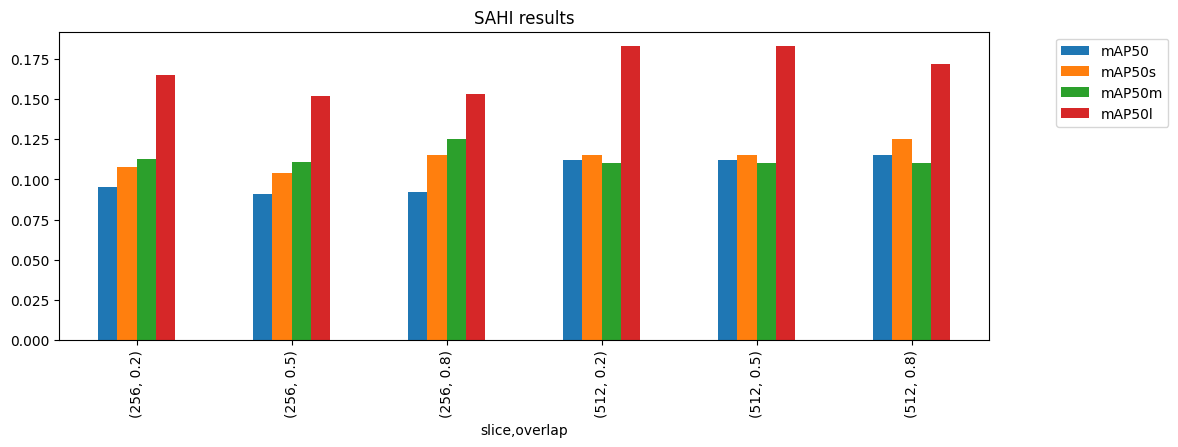

In [35]:
sahi_results.plot(kind='bar', figsize=(12,4));
plt.title("SAHI results");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

### Draw bbox of coco-2017 labels and predicted bbox

In [11]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [12]:
training_data['images']

[{'license': 1,
  'file_name': '000000017627.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000017627.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 15:13:53',
  'flickr_url': 'http://farm5.staticflickr.com/4145/4977243989_c2efb1b911_z.jpg',
  'id': 17627},
 {'license': 3,
  'file_name': '000000025560.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000025560.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-17 21:48:19',
  'flickr_url': 'http://farm1.staticflickr.com/198/488201322_ef2ebfeccb_z.jpg',
  'id': 25560},
 {'license': 3,
  'file_name': '000000016228.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000016228.jpg',
  'height': 440,
  'width': 640,
  'date_captured': '2013-11-19 00:09:53',
  'flickr_url': 'http://farm4.staticflickr.com/3737/10031812195_372ae7538f_z.jpg',
  'id': 16228},
 {'license': 1,
  'file_name': '000000035197.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000035

In [13]:
len(training_data['images'])

200

In [14]:
image_id=7281
for image in training_data['images']:
    if image['id']==image_id:
        image_path = image['file_name']
        break

(-0.5, 639.5, 360.5, -0.5)

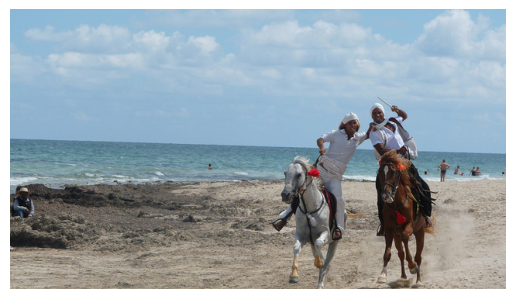

In [15]:
image = cv2.imread(f"coco-2017/validation/data/{image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

In [9]:
def draw_annotations(image, image_id, json_file, color):
    '''
    draw annotations on image with image_id from json_file
    :param image_id:
    :return:
    '''

    f = open(json_file)

    data = json.load(f)

    try:
        annotations = data['annotations']
    except TypeError:
        annotations = data

    for annotation in annotations:
        if annotation['image_id']==image_id and annotation['category_id']==0: #only persons
            box=annotation['bbox']
            x1, y1 = float(box[0]), float(box[1])
            width, height = float(box[2]), float(box[3])
            x2 = x1+width
            y2 = y1+height
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color=color, thickness=2)
    plt.imshow(image)
    plt.axis("off")

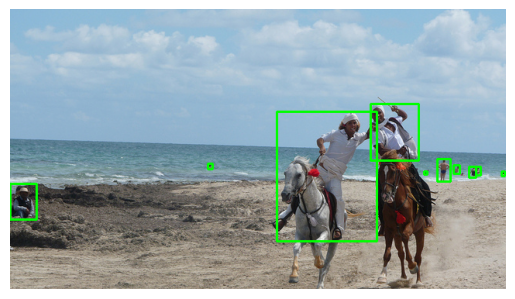

In [17]:
draw_annotations(image, 7281, "coco-2017/validation/new_labels.json", color=(0, 255, 0))

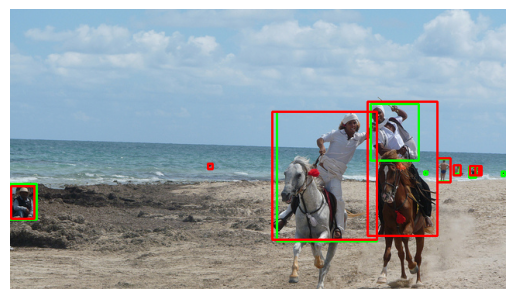

In [18]:
draw_annotations(image, 7281, "runs/predict/yolo_coco_pretrained/yolo_512_02/result.json", color=(255, 0, 0))

In [45]:
# def make_prediction(image_dir, destination_dir):
#
#     for image in glob.glob(f"{image_dir}/*.jpg"):
#
#         predictions = get_sliced_prediction(
#         image,
#         detection_model,
#         slice_height = 512,
#         slice_width = 512,
#         overlap_height_ratio = 0.2,
#         overlap_width_ratio = 0.2
#         )
#
#         print(image)
#         file_name = image.split("\\")[-1].split(".")[0]
#         print(file_name)
#
#         results = predictions.to_coco_annotations()
#
#         with open(f"{destination_dir}/{file_name}.txt", "w+") as f:
#             for result in results:
#                 f.write(str(result['category_id'])+" ")
#                 f.write(" {:.8f}".format(result['score']))
#                 for box in result['bbox']:
#                     f.write(" {:.8f}".format(box))
#                 f.write("\n")


In [ ]:
# make_prediction("test_dataset/images", "test")

In [11]:
def compute_AP50(gt_json, predictions_json, threshold=0.5, plot=True):
    '''
    compute AP50 for batch of images (computes only for person class)
    :param gt_json: json-file with predictions in coco format: tlwh
    :param predictions_json: predictions in coco format: tlwh
    :plot: if True plot Precision-Recall curve
    :return: AP50
    '''

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(10000))

    f = open(gt_json)
    data = json.load(f)
    annotations = data['annotations']
    #images = data['images']

    num_gt=0
    i=0

    images_id=[]

    for annotation in annotations:
        images_id.append(annotation['image_id'])

    images_id = list(set(images_id))

    for image_id in images_id:
        gt_boxes=[]
        for annotation in annotations:
            if annotation['image_id']==image_id and annotation['category_id']==0: #collect gt only for persons
                gt_boxes.append(list(map(lambda x: float(x), annotation['bbox'])))
                #convert from xywh to tlbr
        gt_boxes = [tlwh_tlbr(box) for box in gt_boxes]
        num_gt += len(gt_boxes)


        f = open(predictions_json)
        predictions = json.load(f)
        for result in predictions:
            if result['image_id']==image_id and result['category_id']==0: #select only persons
                pr_box=list(map(lambda x: float(x), result['bbox']))
                pr_box=tlwh_tlbr(pr_box)
                predicted_boxes.loc[i]['confidence']=float(result['score'])
                predicted_boxes.loc[i]['image']=result['image_id']
                ious=[]
                for gt_box in gt_boxes:
                    iou = intersection_over_union(gt_box, pr_box)
                    ious.append(iou)
                if max(ious)>threshold:  #0.50-0.95
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['TP']=1
                    predicted_boxes.loc[i]['FP']=0
                else:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['FP']=1
                    predicted_boxes.loc[i]['TP']=0

                i+=1
            else:
                continue

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False, inplace=True)

    predicted_boxes.reset_index(inplace=True)


    for i in range(len(predicted_boxes)):
        predicted_boxes.loc[i, 'Precision']=predicted_boxes[:i+1]['TP'].sum()/(i+1)
        predicted_boxes.loc[i, 'Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt



    if plot:
        plt.figure(figsize=(9, 4))
        plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
        plt.title("Precision-Recall curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()

    predicted_boxes.dropna(thresh=3, inplace=True)


    ap = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    if plot:
        print(f"AP50 = {ap :.4f}")

    return ap

### Compute AP50-95

In [12]:
def compute_AP50_95(gt_json, predictions_json):
    ap_total = 0
    for threshold in np.arange(0.5, 1.0, 0.05):
        ap_total+=compute_AP50(gt_json,
                               predictions_json,
                               threshold=threshold,
                               plot=False)
    return ap_total/10

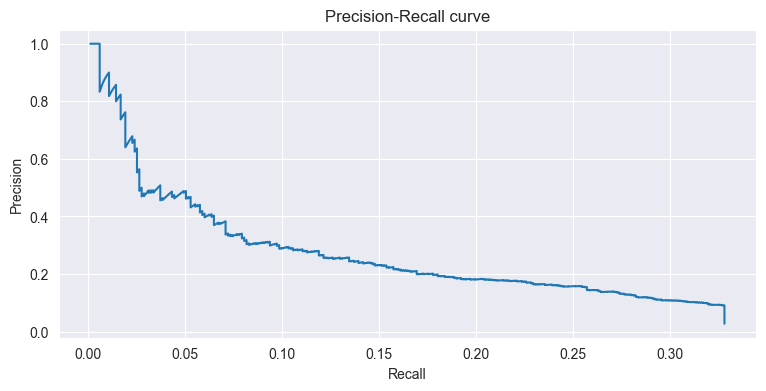

AP50 = 0.0905


In [21]:
AP50 = compute_AP50("coco-2017/validation/new_labels.json", "runs/predict/yolo_coco_finetuned/finetuned_256_05/result.json", plot=True)

In [20]:
AP50_95 = compute_AP50_95("coco-2017/validation/new_labels.json", "runs/predict/yolo_coco_finetuned/finetuned_256_05/result.json")
print(AP50_95)

0.039766886279223604


### Compute metrics for SAHI (YOLOv8 pretrained) on COCO

In [11]:
def compute_metrics(dataframe, results_path, gt_path):
    '''
    :param dataframe: dataframe where AP50 and AP50-95 metrics will be saved
    :param results_path: folder where predictions are saved
    :param gt_path: path to gt labels in coco format
    :return: dataframe with computed metrics
    '''

    for i, dir in enumerate(os.listdir(results_path)):
        parts = dir.split("_")
        slice = int(parts[1])
        overlap = int(parts[2]) / 10
        dataframe.loc[i]['slice'] = slice
        dataframe.loc[i]['overlap'] = overlap


        dataframe.loc[i]['AP50'] = compute_AP50(gt_path,
                                           f"{results_path}/{dir}/result.json",
                                            threshold=0.5,
                                            plot=False)
        dataframe.loc[i]['AP50-95'] = compute_AP50_95(gt_path,
                                            f"{results_path}/{dir}/result.json")
    return dataframe

In [13]:
sahi_yolo_pretrained_coco = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(4))


In [18]:
sahi_yolo_pretrained_coco = compute_metrics(sahi_yolo_pretrained_coco,
                                            "runs/predict/yolo_coco_pretrained",
                                            "coco-2017/validation/new_labels.json")

In [ ]:
sahi_yolo_pretrained_coco.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_pretrained_coco

In [21]:
sahi_yolo_pretrained_coco

AP50   AP50-95
slice overlap                    
256   0.2      0.690546  0.437193
      0.5      0.659684  0.414172
512   0.2      0.653514  0.463824
      0.5      0.653514  0.463824

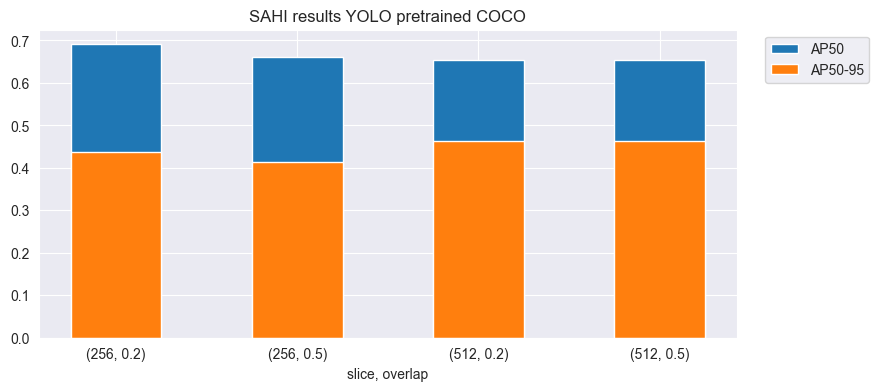

In [101]:
# sahi_yolo_pretrained_coco.plot(kind='bar', stacked=True, figsize=(12,4));
plt.figure(figsize=(9,4))
plt.bar(range(4), sahi_yolo_pretrained_coco['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(4), sahi_yolo_pretrained_coco['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(4), sahi_yolo_pretrained_coco.index);
plt.xlabel("slice, overlap")
plt.title("SAHI results YOLO pretrained COCO");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("sahi_pretrained_coco.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show();

### Compute metrics for SAHI (YOLOv8 fine-tuned) on COCO

In [34]:
sahi_yolo_finetuned_coco = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(4))

sahi_yolo_finetuned_coco = compute_metrics(sahi_yolo_finetuned_coco,
                                            "runs/predict/yolo_coco_finetuned",
                                            "coco-2017/validation/new_labels.json")

In [35]:
sahi_yolo_finetuned_coco.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_finetuned_coco

AP50   AP50-95
slice overlap                    
256   0.2      0.092475  0.040723
      0.5       0.09055  0.039767
512   0.2      0.100312  0.042696
      0.5      0.100312  0.042696

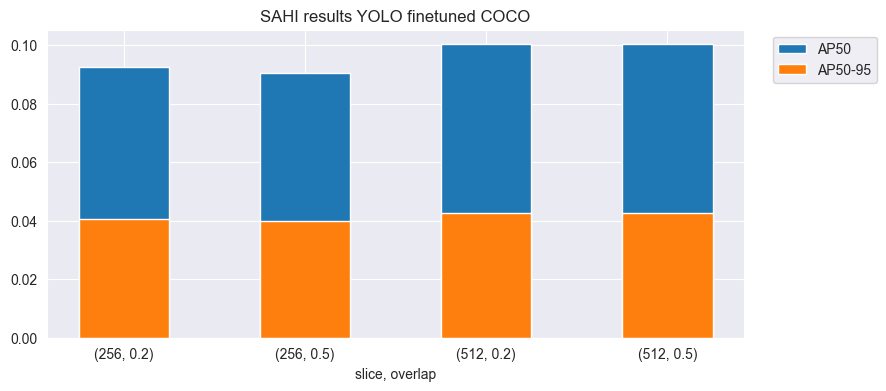

In [100]:
# sahi_yolo_finetuned_coco.plot(kind='bar', stacked=True, figsize=(12,4));
plt.figure(figsize=(9,4))
plt.bar(range(4), sahi_yolo_finetuned_coco['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(4), sahi_yolo_finetuned_coco['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(4), sahi_yolo_pretrained_coco.index);
plt.xlabel("slice, overlap")
plt.title("SAHI results YOLO finetuned COCO");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("sahi_finetuned_coco.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show();

In [28]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [29]:
training_data['images']

[{'license': 1,
  'file_name': '000000017627.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000017627.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 15:13:53',
  'flickr_url': 'http://farm5.staticflickr.com/4145/4977243989_c2efb1b911_z.jpg',
  'id': 17627},
 {'license': 3,
  'file_name': '000000025560.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000025560.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-17 21:48:19',
  'flickr_url': 'http://farm1.staticflickr.com/198/488201322_ef2ebfeccb_z.jpg',
  'id': 25560},
 {'license': 3,
  'file_name': '000000016228.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000016228.jpg',
  'height': 440,
  'width': 640,
  'date_captured': '2013-11-19 00:09:53',
  'flickr_url': 'http://farm4.staticflickr.com/3737/10031812195_372ae7538f_z.jpg',
  'id': 16228},
 {'license': 1,
  'file_name': '000000035197.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000035

In [30]:
image_id=15335
for image in training_data['images']:
    if image['id']==image_id:
        image_path = image['file_name']
        break

(-0.5, 639.5, 479.5, -0.5)

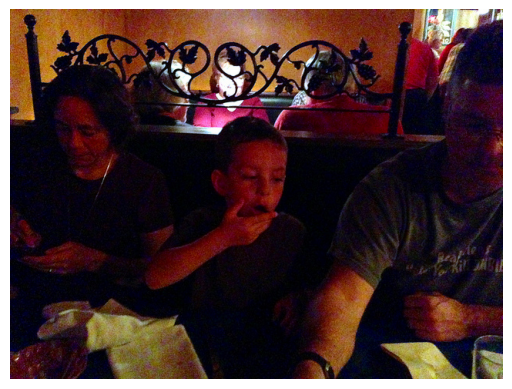

In [31]:
image = cv2.imread(f"coco-2017/validation/data/{image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

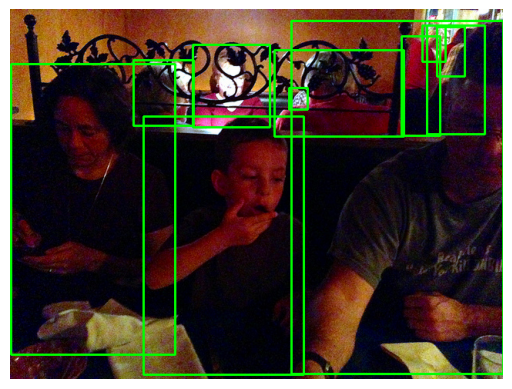

In [32]:
draw_annotations(image, 15335, "coco-2017/validation/new_labels.json", color=(0, 255, 0))

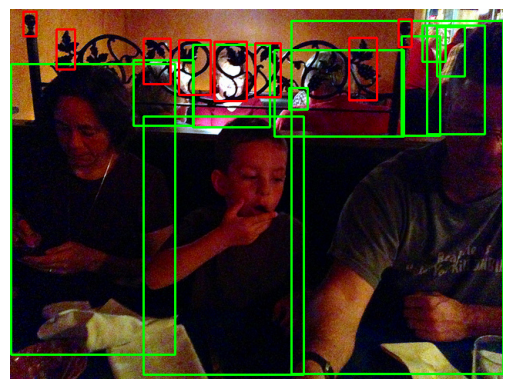

In [33]:
draw_annotations(image, 15335, "runs/predict/yolo_coco_finetuned/finetuned_256_02/result.json", color=(255, 0, 0))

### Compute metrics for SAHI (YOLOv8 pretrained) on PEOPLE

In [34]:
change_annotations_to_yolo("people_test_labels/instances_default.json", "people_test_labels/annotations.json")

In [50]:
sahi_yolo_pretrained_people = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(4))

sahi_yolo_pretrained_people = compute_metrics(sahi_yolo_pretrained_people,
                                            "runs/predict/yolo_people_pretrained",
                                            "people_test_labels/annotations.json")

In [51]:
sahi_yolo_pretrained_people.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_pretrained_people

AP50   AP50-95
slice overlap                    
256   0.2      0.833739  0.555512
      0.5      0.806228  0.518344
512   0.2      0.849305  0.644213
      0.5      0.872985  0.624948

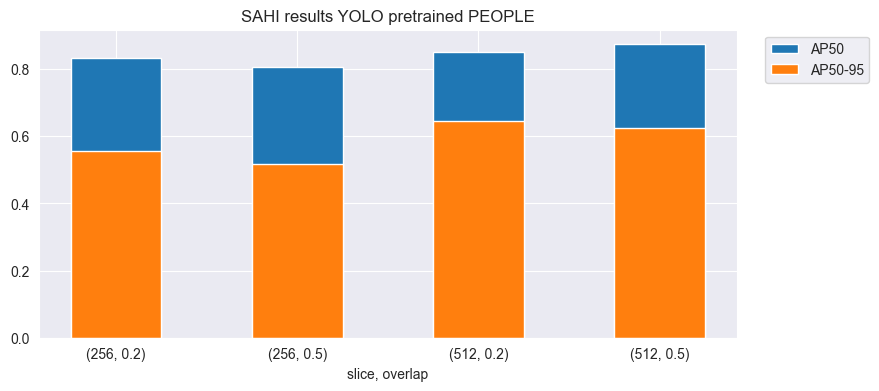

In [99]:
# sahi_yolo_pretrained_people.plot(kind='bar', stacked=True, figsize=(12,4));
plt.figure(figsize=(9,4))
plt.bar(range(4), sahi_yolo_pretrained_people['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(4), sahi_yolo_pretrained_people['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(4), sahi_yolo_pretrained_people.index);
plt.xlabel("slice, overlap")
plt.title("SAHI results YOLO pretrained PEOPLE");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("sahi_pretrained_people.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show();

In [38]:
f = open("people_test_labels/annotations.json")
people_data = json.load(f)

In [39]:
people_data

{'licenses': [{'name': '', 'id': 0, 'url': ''}],
 'info': {'contributor': '',
  'date_created': '',
  'description': '',
  'url': '',
  'version': '',
  'year': ''},
 'categories': [{'id': 0, 'name': 'person', 'supercategory': ''}],
 'images': [{'id': 1,
   'width': 1920,
   'height': 1080,
   'file_name': 'frame1.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 2,
   'width': 1173,
   'height': 880,
   'file_name': 'frame10.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 3,
   'width': 1173,
   'height': 880,
   'file_name': 'frame11.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 4,
   'width': 1173,
   'height': 880,
   'file_name': 'frame12.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 5,
   'width': 1920,
   'height': 1080,
   'file_name': 'frame17.jpg',
   'license': 0,
   'flickr_url': '',

In [40]:
image_id=16
for image in people_data['images']:
    if image['id']==image_id:
        image_path = image['file_name']
        break

(-0.5, 1172.5, 879.5, -0.5)

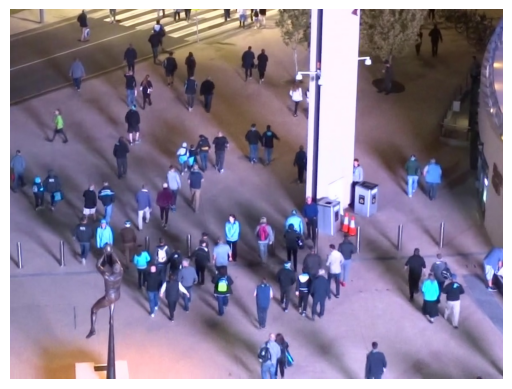

In [41]:
image = cv2.imread(f"people_test_images/{image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

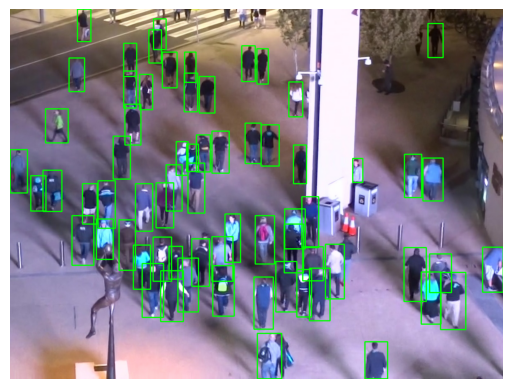

In [42]:
draw_annotations(image, 16, "people_test_labels/annotations.json", color=(0, 255, 0))

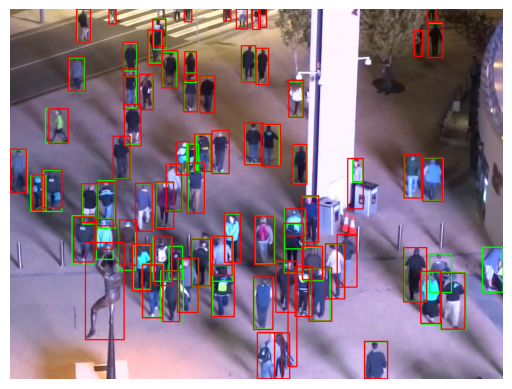

In [43]:
draw_annotations(image, 16, "runs/predict/yolo_people_pretrained/yolo_512_02/result.json", color=(255, 0, 0))

### Compute metrics for SAHI (YOLOv8 finetuned) on PEOPLE

In [39]:
sahi_yolo_finetuned_people = pd.DataFrame(columns=["slice", "overlap", "AP50", "AP50-95"], index=range(4))

sahi_yolo_finetuned_people = compute_metrics(sahi_yolo_finetuned_people,
                                            "runs/predict/yolo_people_finetuned",
                                            "people_test_labels/annotations.json")

In [40]:
sahi_yolo_finetuned_people.set_index(['slice', 'overlap'], inplace=True)
sahi_yolo_finetuned_people

AP50   AP50-95
slice overlap                    
256   0.2      0.715765  0.444789
      0.5      0.715815  0.450083
512   0.2      0.712938  0.435595
      0.5      0.711928  0.438476

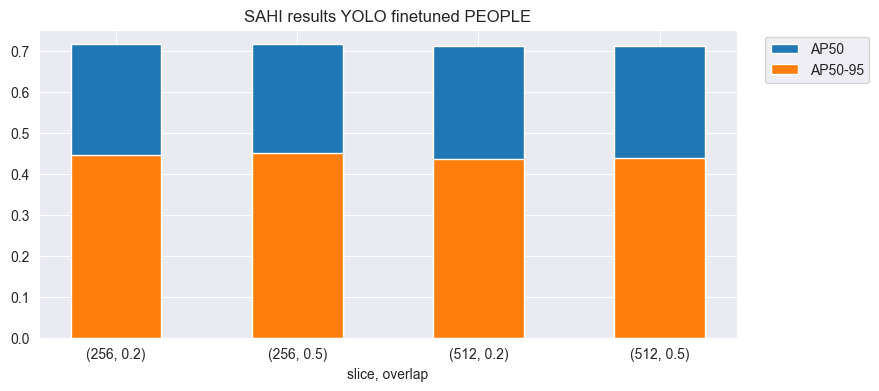

In [98]:
# sahi_yolo_finetuned_people.plot(kind='bar', stacked=True, figsize=(12,4));
plt.figure(figsize=(9,4))
plt.bar(range(4), sahi_yolo_finetuned_people['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(4), sahi_yolo_finetuned_people['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(4), sahi_yolo_pretrained_coco.index);
plt.xlabel("slice, overlap")
plt.title("SAHI results YOLO finetuned PEOPLE");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("sahi_finetuned_people.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show();

In [47]:
f = open("people_test_labels/annotations.json")
people_data = json.load(f)

In [52]:
people_data['images']

[{'id': 1,
  'width': 1920,
  'height': 1080,
  'file_name': 'frame1.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 2,
  'width': 1173,
  'height': 880,
  'file_name': 'frame10.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 3,
  'width': 1173,
  'height': 880,
  'file_name': 'frame11.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 4,
  'width': 1173,
  'height': 880,
  'file_name': 'frame12.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 5,
  'width': 1920,
  'height': 1080,
  'file_name': 'frame17.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 6,
  'width': 1920,
  'height': 1080,
  'file_name': 'frame18.jpg',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0},
 {'id': 7,
  'width': 1920,
  'height': 1080,
  'file_name': 'frame19.jpg',
  'license

In [61]:
image_id=7
for image in people_data['images']:
    if image['id']==image_id:
        image_path = image['file_name']
        break

(-0.5, 1919.5, 1079.5, -0.5)

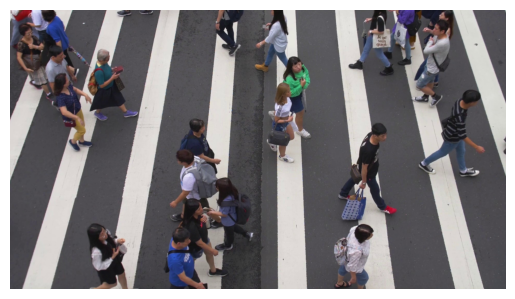

In [62]:
image = cv2.imread(f"people_test_images/{image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

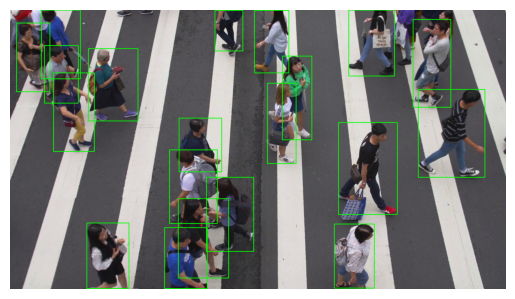

In [63]:
draw_annotations(image, 7, "people_test_labels/annotations.json", color=(0, 255, 0))

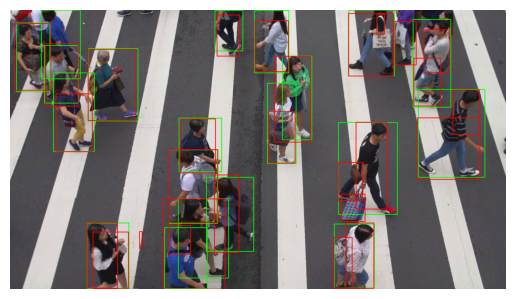

In [64]:
draw_annotations(image, 7, "runs/predict/yolo_people_finetuned/finetuned_512_02/result.json", color=(255, 0, 0))

## All plots

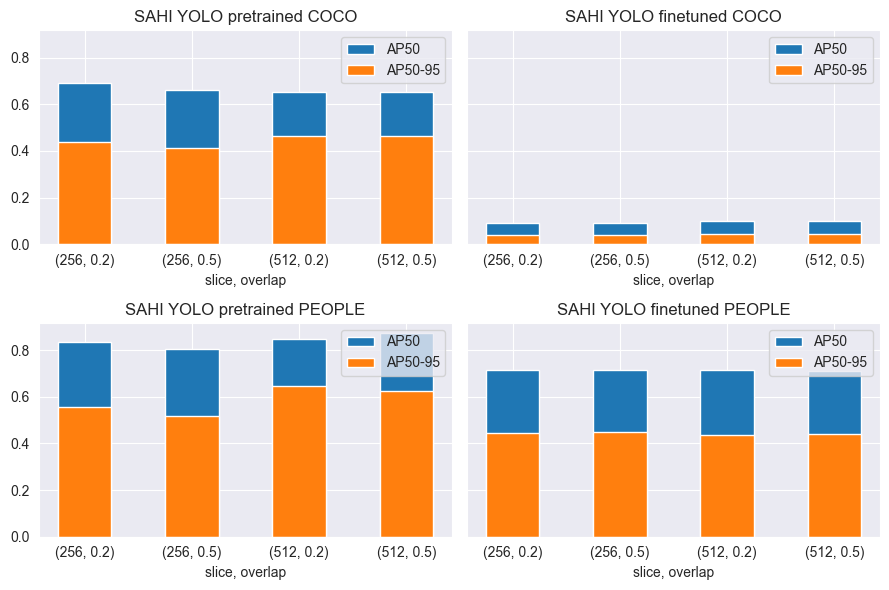

In [103]:
fig, axis = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(9,6))
# sahi_yolo_pretrained_coco.plot(kind='bar', stacked=True, ax=axis[0,0], figsize=(9,6))
axis[0,0].bar(range(4), sahi_yolo_pretrained_coco['AP50'], align='center', width=0.5, label="AP50");
axis[0,0].bar(range(4), sahi_yolo_pretrained_coco['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[0,0].set_xticks(range(4), sahi_yolo_pretrained_coco.index);
axis[0,0].set_xlabel("slice, overlap")
axis[0,0].set_title("SAHI YOLO pretrained COCO")
axis[0,0].legend(loc="upper right")
# sahi_yolo_finetuned_coco.plot(kind='bar', stacked=True, ax=axis[0,1], figsize=(9,6))
axis[0,1].bar(range(4), sahi_yolo_finetuned_coco['AP50'], align='center', width=0.5, label="AP50");
axis[0,1].bar(range(4), sahi_yolo_finetuned_coco['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[0,1].set_xticks(range(4), sahi_yolo_finetuned_coco.index);
axis[0,1].set_xlabel("slice, overlap")
axis[0,1].set_title("SAHI YOLO finetuned COCO")
axis[0,1].legend(loc="upper right")

#sahi_yolo_pretrained_people.plot(kind='bar', stacked=True, ax=axis[1,0], figsize=(9,6))
axis[1,0].bar(range(4), sahi_yolo_pretrained_people['AP50'], align='center', width=0.5, label="AP50");
axis[1,0].bar(range(4), sahi_yolo_pretrained_people['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[1,0].set_xticks(range(4), sahi_yolo_pretrained_people.index);
axis[1,0].set_xlabel("slice, overlap")
axis[1,0].set_title("SAHI YOLO pretrained PEOPLE")
axis[1,0].legend(loc="upper right")
#sahi_yolo_finetuned_people.plot(kind='bar', stacked=True, ax=axis[1,1], figsize=(9,6))
axis[1,1].bar(range(4), sahi_yolo_finetuned_people['AP50'], align='center', width=0.5, label="AP50");
axis[1,1].bar(range(4), sahi_yolo_finetuned_people['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[1,1].set_xticks(range(4), sahi_yolo_finetuned_people.index);
axis[1,1].set_xlabel("slice, overlap")
axis[1,1].set_title("SAHI YOLO finetuned PEOPLE")
axis[1,1].legend(loc="upper right")

plt.tight_layout()
plt.savefig("all.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show()

### Simple YOLO results without SAHI

In [46]:
simple_yolo = pd.DataFrame(index=range(4), columns=['data', 'model', 'AP50', 'AP50-95'])

In [47]:
results_path = "runs/predict"

for i, dir in enumerate(["yolo_no_slice_coco_pretrained",
               "yolo_no_slice_coco_finetuned",
               "yolo_no_slice_people_pretrained",
               "yolo_no_slice_people_finetuned"]):
    parts = dir.split("_")
    model = parts[-1]
    data = parts[-2]
    simple_yolo.loc[i]['model'] = model
    simple_yolo.loc[i]['data'] = data

    if data=='people':
        gt_path = "people_test_labels/annotations.json"
    else:
        gt_path = "coco-2017/validation/new_labels.json"


    simple_yolo.loc[i]['AP50'] = compute_AP50(gt_path,
                                           f"{results_path}/{dir}/result.json",
                                            threshold=0.5,
                                            plot=False)
    simple_yolo.loc[i]['AP50-95'] = compute_AP50_95(gt_path,
                                            f"{results_path}/{dir}/result.json")

In [48]:
simple_yolo.set_index(['data', 'model'], inplace=True)
simple_yolo

AP50   AP50-95
data   model                         
coco   pretrained  0.736343  0.546552
       finetuned   0.104646  0.044386
people pretrained  0.642613  0.550246
       finetuned   0.823119  0.525977

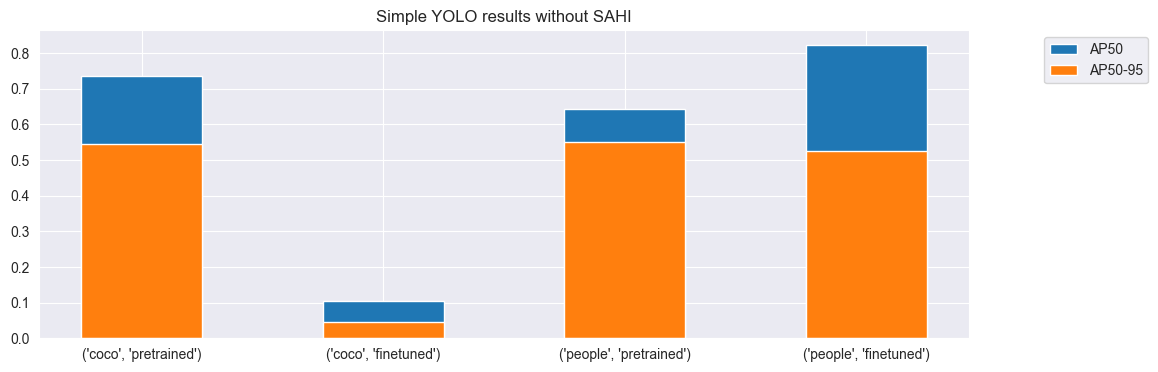

In [49]:
#simple_yolo.plot(kind='bar', stacked=True, figsize=(12,4));
plt.figure(figsize=(12,4))
plt.bar(range(4), simple_yolo['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(4), simple_yolo['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(4), simple_yolo.index);
plt.title("Simple YOLO results without SAHI");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("yolo_without_sahi.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show();

### Pretrained YOLOv8 with SAHI and different postprocess overlap parameters on PEOPLE

Used sliding window [320, 640] and different **--postprocess_match_threshold** and **---postprocess_match_metric**
**overlap** 0.2

In [57]:
pretrained_yolo_sahi = pd.DataFrame(index=range(12), columns=['slice', 'postprocess_match_threshold',
                                                             'postprocess_match_metric',
                                                             'AP50', 'AP50-95'])

In [59]:
def compute_metrics_for_people(dataframe, results_path, gt_path):
    '''
    :param dataframe: dataframe where AP50 and AP50-95 metrics will be saved
    :param results_path: folder where predictions are saved
    :param gt_path: path to gt labels in coco format
    :return: dataframe with computed metrics
    '''

    for i, dir in enumerate(os.listdir(results_path)):
        parts = dir.split("_")
        slice = int(parts[-3])
        match_threshold = int(parts[-2]) / 10
        match_metric = parts[-1]

        dataframe.loc[i]['slice'] = slice
        dataframe.loc[i]['postprocess_match_threshold'] = match_threshold
        dataframe.loc[i]['postprocess_match_metric'] = match_metric



        dataframe.loc[i]['AP50'] = compute_AP50(gt_path,
                                           f"{results_path}/{dir}/result.json",
                                            threshold=0.5,
                                            plot=False)
        dataframe.loc[i]['AP50-95'] = compute_AP50_95(gt_path,
                                            f"{results_path}/{dir}/result.json")
    return dataframe

In [60]:
pretrained_yolo_sahi = compute_metrics_for_people(pretrained_yolo_sahi, "runs/predict/sahi_people",
                                                  "people_test_labels/annotations.json")

In [61]:
pretrained_yolo_sahi

slice postprocess_match_threshold postprocess_match_metric      AP50  \
0    320                         0.1                      IOS  0.334252   
1    320                         0.1                      IOU   0.59131   
2    320                         0.3                      IOS  0.700007   
3    320                         0.3                      IOU  0.809908   
4    320                         0.5                      IOS  0.873429   
5    320                         0.5                      IOU  0.722435   
6    640                         0.1                      IOS  0.397054   
7    640                         0.1                      IOU  0.590672   
8    640                         0.3                      IOS  0.709929   
9    640                         0.3                      IOU  0.809167   
10   640                         0.5                      IOS  0.833989   
11   640                         0.5                      IOU  0.767463   

     AP50-95  
0   0.178763  
1   0.376976  
2   0.440388  
3   0.563096  
4    0.57642  
5    0.50317  
6   0.198789  
7   0.356067  
8   0.459404  
9   0.657474  
10  0.642097  
11  0.624325

In [62]:
pretrained_yolo_sahi_320 = pretrained_yolo_sahi[pretrained_yolo_sahi['slice']==320]
pretrained_yolo_sahi_640 = pretrained_yolo_sahi[pretrained_yolo_sahi['slice']==640]

In [63]:
pretrained_yolo_sahi_320

slice postprocess_match_threshold postprocess_match_metric      AP50  \
0   320                         0.1                      IOS  0.334252   
1   320                         0.1                      IOU   0.59131   
2   320                         0.3                      IOS  0.700007   
3   320                         0.3                      IOU  0.809908   
4   320                         0.5                      IOS  0.873429   
5   320                         0.5                      IOU  0.722435   

    AP50-95  
0  0.178763  
1  0.376976  
2  0.440388  
3  0.563096  
4   0.57642  
5   0.50317

In [64]:
pretrained_yolo_sahi_640

slice postprocess_match_threshold postprocess_match_metric      AP50  \
6    640                         0.1                      IOS  0.397054   
7    640                         0.1                      IOU  0.590672   
8    640                         0.3                      IOS  0.709929   
9    640                         0.3                      IOU  0.809167   
10   640                         0.5                      IOS  0.833989   
11   640                         0.5                      IOU  0.767463   

     AP50-95  
6   0.198789  
7   0.356067  
8   0.459404  
9   0.657474  
10  0.642097  
11  0.624325

In [65]:
pretrained_yolo_sahi_320.set_index(['postprocess_match_threshold', 'postprocess_match_metric'], inplace=True)
pretrained_yolo_sahi_640.set_index(['postprocess_match_threshold', 'postprocess_match_metric'], inplace=True)

In [66]:
pretrained_yolo_sahi_320.drop(['slice'], axis=1, inplace=True)
pretrained_yolo_sahi_640.drop(['slice'], axis=1, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_3424\3347284973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_yolo_sahi_320.drop(['slice'], axis=1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_3424\3347284973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_yolo_sahi_640.drop(['slice'], axis=1, inplace=True)


In [67]:
pretrained_yolo_sahi_320

AP50   AP50-95
postprocess_match_threshold postprocess_match_metric                    
0.1                         IOS                       0.334252  0.178763
                            IOU                        0.59131  0.376976
0.3                         IOS                       0.700007  0.440388
                            IOU                       0.809908  0.563096
0.5                         IOS                       0.873429   0.57642
                            IOU                       0.722435   0.50317

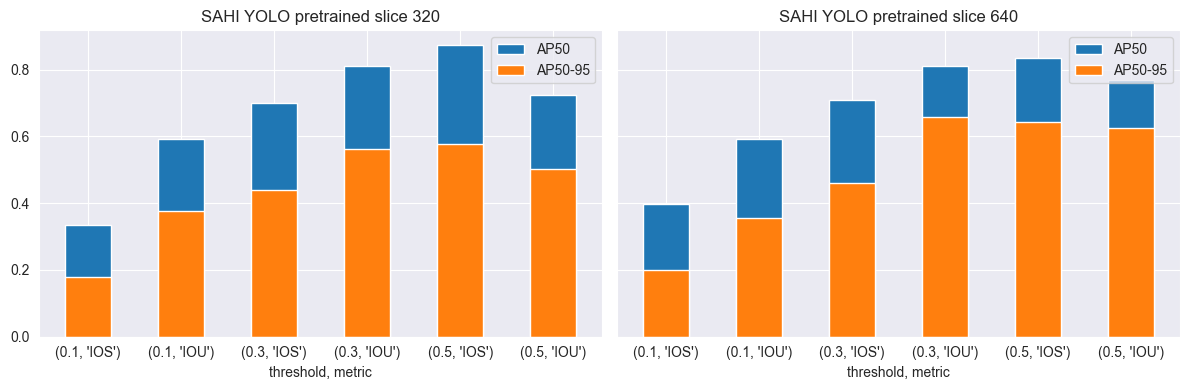

In [83]:
fig, axis = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
#pretrained_yolo_sahi_320.plot(kind='bar', stacked=True, ax=axis[0], figsize=(9,4))
axis[0].bar(range(6), pretrained_yolo_sahi_320['AP50'], align='center', width=0.5, label="AP50");
axis[0].bar(range(6), pretrained_yolo_sahi_320['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[0].set_xticks(range(6), pretrained_yolo_sahi_320.index);
axis[0].set_title("SAHI YOLO pretrained slice 320")
axis[0].legend(loc="upper right")
axis[0].set_xlabel("threshold, metric")
#pretrained_yolo_sahi_640.plot(kind='bar', stacked=True, ax=axis[1], figsize=(9,4))
axis[1].bar(range(6), pretrained_yolo_sahi_640['AP50'], align='center', width=0.5, label="AP50");
axis[1].bar(range(6), pretrained_yolo_sahi_640['AP50-95'], align='center', width=0.5, label="AP50-95");
axis[1].set_xticks(range(6), pretrained_yolo_sahi_640.index);
axis[1].set_title("SAHI YOLO pretrained slice 640")
axis[1].legend(loc="upper right")
axis[1].set_xlabel("threshold, metric")
plt.savefig("sahi_pretrained_people_320_640.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.tight_layout()
plt.show()

### Compare metrics with SAHI (best results slice 320 and IOS 0.5) and without for PEOPLE dataset (YOLO finetuned on people)

In [12]:
people_with_and_without_sahi_320 = pd.DataFrame(index=range(2), columns=['SAHI','AP50', 'AP50-95'])

In [13]:
#with SAHI best results IOS and slice 640
people_with_and_without_sahi_320.loc[0]['SAHI']='with SAHI'
people_with_and_without_sahi_320.loc[0]['AP50']=compute_AP50("people_test_labels/annotations.json",
                                           "runs/predict/sahi_people/sahi_people_pretrained_320_05_IOS/result.json",
                                            threshold=0.5,
                                            plot=False)

people_with_and_without_sahi_320.loc[0]['AP50-95'] = compute_AP50_95("people_test_labels/annotations.json",
                                            "runs/predict/sahi_people/sahi_people_pretrained_320_05_IOS/result.json")


#without SAHI
people_with_and_without_sahi_320.loc[1]['SAHI']='without SAHI'
people_with_and_without_sahi_320.loc[1]['AP50']=compute_AP50("people_test_labels/annotations.json",
                                           "runs/predict/yolo_no_slice_people_finetuned/result.json",
                                            threshold=0.5,
                                            plot=False)

people_with_and_without_sahi_320.loc[1]['AP50-95'] = compute_AP50_95("people_test_labels/annotations.json",
                                            "runs/predict/yolo_no_slice_people_finetuned/result.json")


In [14]:
people_with_and_without_sahi_320

SAHI      AP50   AP50-95
0     with SAHI  0.873429   0.57642
1  without SAHI  0.823119  0.525977

In [15]:
people_with_and_without_sahi_320.set_index(['SAHI'], inplace=True)

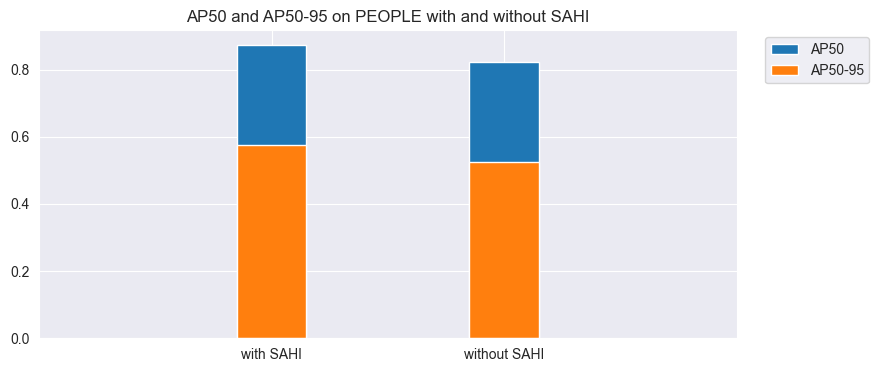

In [16]:
#people_with_and_without_sahi_640.plot(kind='bar', stacked=True, figsize=(9,4))
plt.figure(figsize=(9,4))
plt.bar(range(2), people_with_and_without_sahi_320['AP50'], align='center', width=0.3, label="AP50");
plt.bar(range(2), people_with_and_without_sahi_320['AP50-95'], align='center', width=0.3, label="AP50-95");
plt.xlim([-1, 2])
plt.xticks(ticks=[0, 1], labels=['with SAHI', 'without SAHI'], rotation=0)
plt.title("AP50 and AP50-95 on PEOPLE with and without SAHI");
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.savefig("people_with_and_without_SAHI.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.show()

### Compute match-threshold and match-metric for COCO (slice 320, because 640 - is just one slice = without sahi)

In [87]:
pretrained_yolo_sahi_coco = pd.DataFrame(index=range(6), columns=['slice', 'postprocess_match_threshold',
                                                             'postprocess_match_metric',
                                                             'AP50', 'AP50-95'])

In [88]:
pretrained_yolo_sahi_coco = compute_metrics_for_people(pretrained_yolo_sahi_coco, "runs/predict/sahi_coco",
                                                  "coco-2017/validation/new_labels.json")

In [89]:
pretrained_yolo_sahi_coco

slice postprocess_match_threshold postprocess_match_metric      AP50  \
0   320                         0.1                      IOS  0.495201   
1   320                         0.1                      IOU  0.610408   
2   320                         0.3                      IOS  0.597749   
3   320                         0.3                      IOU  0.649029   
4   320                         0.5                      IOS  0.657886   
5   320                         0.5                      IOU  0.600498   

    AP50-95  
0  0.274043  
1   0.37218  
2  0.365037  
3    0.4532  
4  0.436725  
5  0.405896

In [90]:
pretrained_yolo_sahi_coco.drop(['slice'], axis=1, inplace=True)

In [91]:
pretrained_yolo_sahi_coco.set_index(['postprocess_match_threshold', 'postprocess_match_metric'], inplace=True)

In [92]:
pretrained_yolo_sahi_coco

AP50   AP50-95
postprocess_match_threshold postprocess_match_metric                    
0.1                         IOS                       0.495201  0.274043
                            IOU                       0.610408   0.37218
0.3                         IOS                       0.597749  0.365037
                            IOU                       0.649029    0.4532
0.5                         IOS                       0.657886  0.436725
                            IOU                       0.600498  0.405896

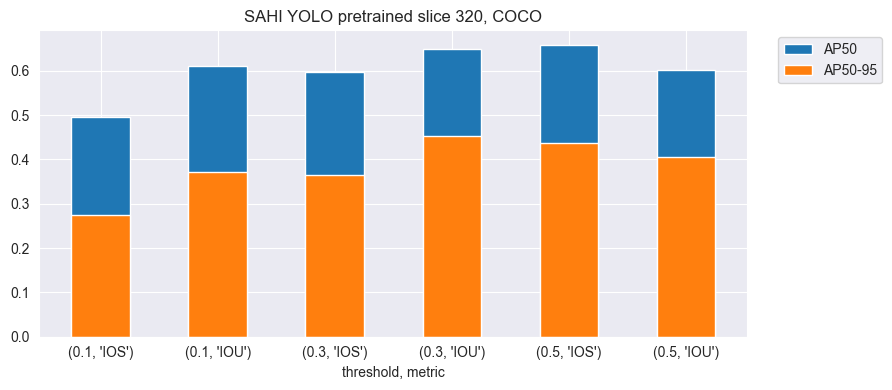

In [109]:
#pretrained_yolo_sahi_coco.plot(kind='bar', stacked=True, figsize=(9,4))
plt.figure(figsize=(9,4))
plt.bar(range(6), pretrained_yolo_sahi_coco['AP50'], align='center', width=0.5, label="AP50");
plt.bar(range(6), pretrained_yolo_sahi_coco['AP50-95'], align='center', width=0.5, label="AP50-95");
plt.xticks(range(6), pretrained_yolo_sahi_coco.index);
plt.title("SAHI YOLO pretrained slice 320, COCO")
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.xlabel("threshold, metric");
plt.savefig("sahi_pretrained_coco_320.png", bbox_inches="tight",
            pad_inches=0.3,)
plt.tight_layout()
plt.show()

### Compare metrics with SAHI (best results slice 320 and IOS 0.5) and without for COCO dataset

In [94]:
coco_with_and_without_sahi_320 = pd.DataFrame(index=range(2), columns=['SAHI','AP50', 'AP50-95'])

In [95]:
#with SAHI best results IOS and slice 640
coco_with_and_without_sahi_320.loc[0]['SAHI']='with SAHI'
coco_with_and_without_sahi_320.loc[0]['AP50']=compute_AP50("coco-2017/validation/new_labels.json",
                                           "runs/predict/sahi_coco/sahi_coco_pretrained_320_05_IOS/result.json",
                                            threshold=0.5,
                                            plot=False)

coco_with_and_without_sahi_320.loc[0]['AP50-95'] = compute_AP50_95("coco-2017/validation/new_labels.json",
                                            "runs/predict/sahi_coco/sahi_coco_pretrained_320_05_IOS/result.json")


#without SAHI
coco_with_and_without_sahi_320.loc[1]['SAHI']='without SAHI'
coco_with_and_without_sahi_320.loc[1]['AP50']=compute_AP50("coco-2017/validation/new_labels.json",
                                           "runs/predict/yolo_no_slice_coco_pretrained/result.json",
                                            threshold=0.5,
                                            plot=False)

coco_with_and_without_sahi_320.loc[1]['AP50-95'] = compute_AP50_95("coco-2017/validation/new_labels.json",
                                            "runs/predict/yolo_no_slice_coco_pretrained/result.json")

In [96]:
coco_with_and_without_sahi_320.set_index(['SAHI'], inplace=True)

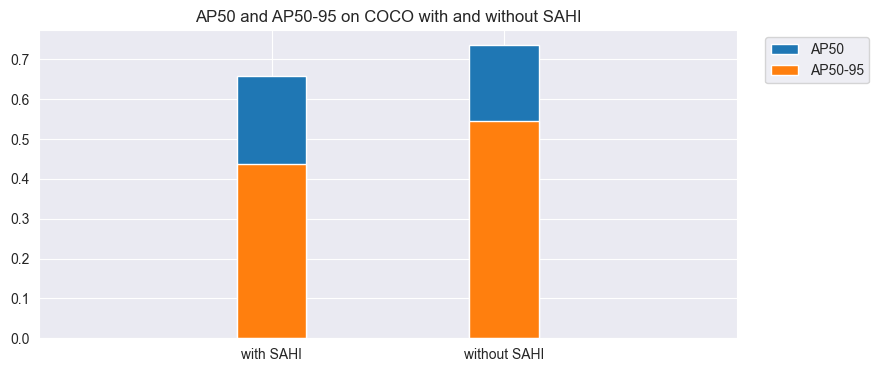

In [124]:
#coco_with_and_without_sahi_320.plot(kind='bar', stacked=True, figsize=(9, 4))
plt.figure(figsize=(9,4))
plt.bar(range(2), coco_with_and_without_sahi_320['AP50'], align='center', width=0.3, label="AP50");
plt.bar(range(2), coco_with_and_without_sahi_320['AP50-95'], align='center', width=0.3, label="AP50-95");
plt.xlim([-1, 2])
plt.xticks(ticks=[0,1], labels=['with SAHI', 'without SAHI'], rotation=0)
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.title("AP50 and AP50-95 on COCO with and without SAHI");
plt.xlabel('')
plt.savefig("coco_with_and_without_SAHI.png", bbox_inches="tight",
            pad_inches=0.3, )
plt.show()

### Compute time and number of slices for 1 image

(-0.5, 1919.5, 1079.5, -0.5)

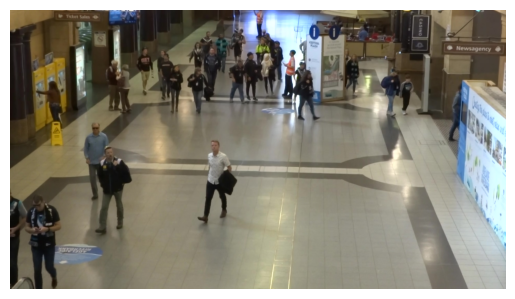

In [13]:
image = cv2.imread(f"people_test_images/frame6.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis("off")

In [14]:
print(image.shape)

(1080, 1920, 3)


In [15]:
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [16]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1",  # or 'cuda:0'
)

In [17]:
from sahi.slicing import slice_image

In [18]:
def compute_num_slices(image, slice_height, slice_width, overlap_height_ratio, overlap_width_ratio):
     slice_image_result = slice_image(
        image=image,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio
    )
     return len(slice_image_result)

In [19]:
slice_list = [256, 320, 512, 640]
overlap_list = [0.2, 0.5]

In [20]:
time_slice_number_df = pd.DataFrame(index=range(8), columns=['slice', 'overlap', 'prediction_time', 'num_slices'])

In [21]:
i=0
for slice in slice_list:
    for overlap in overlap_list:
        slice_width = slice_height = slice
        overlap_height_ratio = overlap_width_ratio = overlap
        num_slices = compute_num_slices(image,
                                        slice_width, slice_height,
                                        overlap_height_ratio, overlap_width_ratio)
        result = get_sliced_prediction(
            image,
            detection_model,
            slice_height = slice_height,
            slice_width = slice_width,
            overlap_height_ratio = overlap_height_ratio,
            overlap_width_ratio = overlap_width_ratio
        )
        time_slice_number_df.loc[i]['slice']=slice
        time_slice_number_df.loc[i]['overlap']=overlap
        time_slice_number_df.loc[i]['prediction_time']=result.durations_in_seconds['prediction']
        time_slice_number_df.loc[i]['num_slices']=num_slices
        i+=1

Performing prediction on 60 number of slices.
Performing prediction on 112 number of slices.
Performing prediction on 32 number of slices.
Performing prediction on 66 number of slices.
Performing prediction on 15 number of slices.
Performing prediction on 28 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 15 number of slices.


In [22]:
time_slice_number_df

slice overlap prediction_time num_slices
0   256     0.2      383.925939         60
1   256     0.5      534.171499        112
2   320     0.2      151.402017         32
3   320     0.5      318.224359         66
4   512     0.2       76.347594         15
5   512     0.5      138.973835         28
6   640     0.2       37.963285          8
7   640     0.5       80.552478         15

In [23]:
time_slice_number_320 = time_slice_number_df[time_slice_number_df['slice']==320]

In [24]:
time_slice_df = time_slice_number_df[['num_slices', 'prediction_time']].sort_values(['num_slices'])

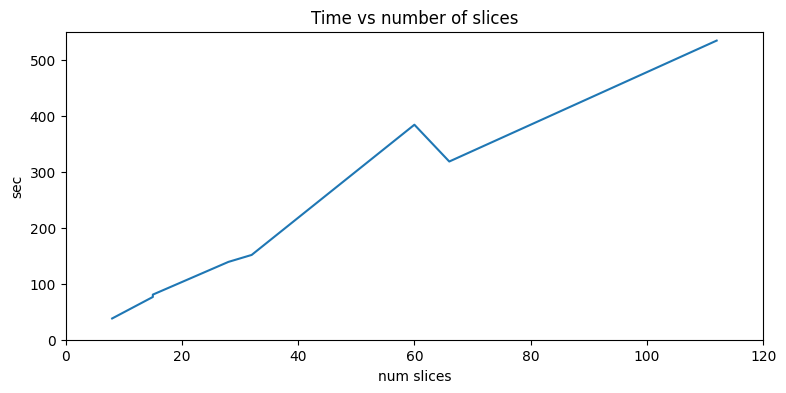

In [30]:
plt.figure(figsize=(9,4))
plt.title("Time vs number of slices")
plt.plot(time_slice_df['num_slices'], time_slice_df['prediction_time'])
plt.xlim([0, 120])
plt.ylim([0, 550])
plt.xlabel("num slices")
plt.ylabel("sec")
plt.savefig("time_slice.png", bbox_inches="tight",
            pad_inches=0.3, )
plt.show()

In [31]:
result.durations_in_seconds

{'slice': 0.011312246322631836, 'prediction': 80.55247783660889}

In [28]:
result.object_prediction_list

[ObjectPrediction<
     bbox: BoundingBox: <(55.502403259277344, 714.060546875, 198.12738037109375, 1077.8519287109375), w: 142.6249771118164, h: 363.7913818359375>,
     mask: None,
     score: PredictionScore: <value: 0.9362876415252686>,
     category: Category: <id: 0, name: person>>,
 ObjectPrediction<
     bbox: BoundingBox: <(281.6968688964844, 434.035400390625, 383.1199951171875, 736.5455932617188), w: 101.42312622070312, h: 302.51019287109375>,
     mask: None,
     score: PredictionScore: <value: 0.9330340623855591>,
     category: Category: <id: 0, name: person>>,
 ObjectPrediction<
     bbox: BoundingBox: <(53.74299240112305, 820.2611572146416, 197.83700561523438, 1079.610107421875), w: 144.09401321411133, h: 259.34895020723343>,
     mask: None,
     score: PredictionScore: <value: 0.9233009219169617>,
     category: Category: <id: 0, name: person>>,
 ObjectPrediction<
     bbox: BoundingBox: <(325.8152770996094, 523.7772216796875, 474.23089599609375, 871.517822265625), w:

#### Plot time durations of predictions for each image from the people folder with different slices (320 and 640)

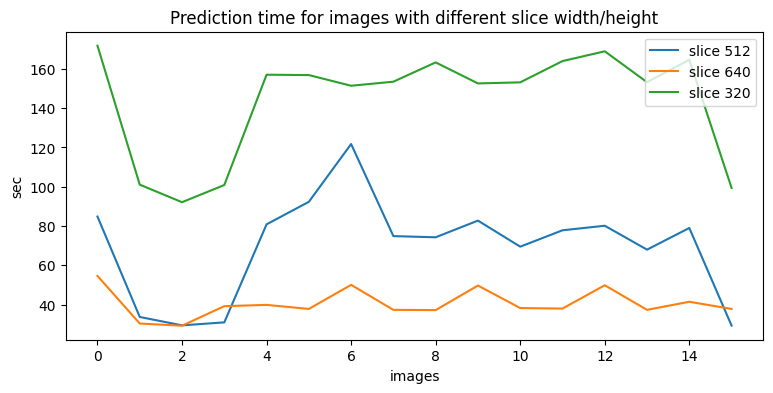

In [48]:
plt.figure(figsize=(9,4))
for i, dir in enumerate(os.listdir("runs/predict")):
    parts = dir.split("_")
    slice = int(parts[-1])
    with open(f"runs/predict/{dir}/prediction_time/prediction_time.txt", "r") as f:
        lines = f.readlines()
    prediction_time = list(map(float, lines[0].split(" ")))
    plt.plot(range(len(prediction_time)), prediction_time, label=f"slice {slice}")

plt.title("Prediction time for images with different slice width/height") 
plt.legend(loc="upper right")  
plt.xlabel("images")
plt.ylabel("sec") 
plt.savefig("prediction_time_320_512_640.png", bbox_inches="tight",
            pad_inches=0.3)
plt.show()

In [129]:
def show_annotations(image_dir, annotations_dir):
    image = cv2.imread(image_dir)

    height, width = image.shape[:2]


    with open(annotations_dir, "r") as f:
        boxes = f.readlines()

    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()




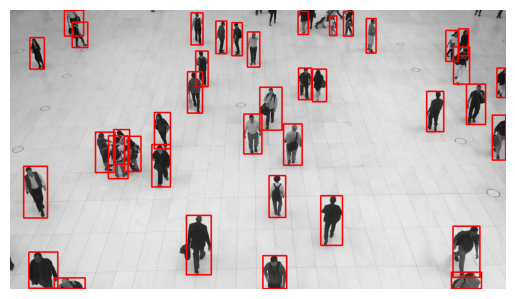

In [130]:
show_annotations("datasets/images/people_frames_113.jpg", "datasets/labels/people_frames_113.txt")

In [37]:
import torch

In [78]:
object_predictions_as_tensor = torch.tensor([[114, 234, 200, 300, 0.9],
                                             [90, 180, 150, 220, 0.89],
                                             [100, 200, 230, 350, 0.7],
                                             [45, 70, 80, 100, 0.76],
                                             [150, 210, 240, 300, 0.87]])

In [122]:
object_predictions_as_tensor

tensor([[114.0000, 234.0000, 200.0000, 300.0000,   0.9000],
        [ 90.0000, 180.0000, 150.0000, 220.0000,   0.8900],
        [100.0000, 200.0000, 230.0000, 350.0000,   0.7000],
        [ 45.0000,  70.0000,  80.0000, 100.0000,   0.7600],
        [150.0000, 210.0000, 240.0000, 300.0000,   0.8700]])

In [123]:
image = np.zeros(shape=(640, 640), dtype='uint8')

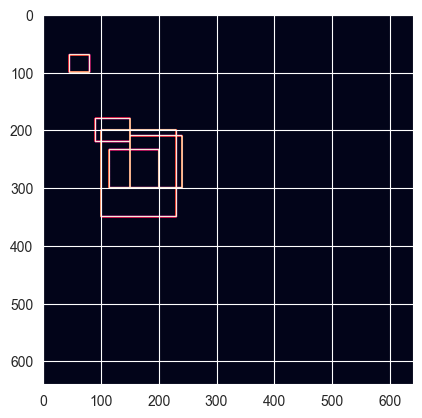

In [124]:
for rect in object_predictions_as_tensor:
    rect = rect.numpy()
    cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[2]), int(rect[3])), color=(255,0,0), thickness=2)
plt.imshow(image)

In [125]:
def greedy_nmm(
    object_predictions_as_tensor: torch.tensor,
    match_metric: str = "IOS",
    match_threshold: float = 0.5,
):
    """
    Apply greedy version of non-maximum merging to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        object_predictions_as_tensor: (tensor) The location preds for the image
            along with the class predscores, Shape: [num_boxes,5].
        object_predictions_as_list: ObjectPredictionList Object prediction objects
            to be merged.
        match_metric: (str) IOU or IOS
        match_threshold: (float) The overlap thresh for
            match metric.
    Returns:
        keep_to_merge_list: (Dict[int:List[int]]) mapping from prediction indices
        to keep to a list of prediction indices to be merged.
    """
    keep_to_merge_list = {}

    # we extract coordinates for every
    # prediction box present in P
    x1 = object_predictions_as_tensor[:, 0]
    y1 = object_predictions_as_tensor[:, 1]
    x2 = object_predictions_as_tensor[:, 2]
    y2 = object_predictions_as_tensor[:, 3]

    # we extract the confidence scores as well
    scores = object_predictions_as_tensor[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()


    # initialise an empty list for
    # filtered prediction boxes
    keep = []

    while len(order) > 0:
        print(order)
        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
        print(idx)

        # push S in filtered predictions list
        keep.append(idx.tolist())

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            keep_to_merge_list[idx.tolist()] = []
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1, dim=0, index=order)
        xx2 = torch.index_select(x2, dim=0, index=order)
        yy1 = torch.index_select(y1, dim=0, index=order)
        yy2 = torch.index_select(y2, dim=0, index=order)

        print(xx1)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])



        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w * h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim=0, index=order)

        if match_metric == "IOU":
            # find the union of every prediction T in P
            # with the prediction S
            # Note that areas[idx] represents area of S
            union = (rem_areas - inter) + areas[idx]
            # find the IoU of every prediction in P with S
            match_metric_value = inter / union

        elif match_metric == "IOS":
            # find the smaller area of every prediction T in P
            # with the prediction S
            # Note that areas[idx] represents area of S
            smaller = torch.min(rem_areas, areas[idx])
            # find the IoS of every prediction in P with S
            match_metric_value = inter / smaller
        else:
            raise ValueError()

        # keep the boxes with IoU/IoS less than thresh_iou
        print(match_metric_value)
        mask = match_metric_value < match_threshold
        matched_box_indices = order[(mask == False).nonzero().flatten()].flip(dims=(0,))
        print(order[(mask == False).nonzero().flatten()])
        print(matched_box_indices)
        unmatched_indices = order[(mask == True).nonzero().flatten()]

        # update box pool
        order = unmatched_indices[scores[unmatched_indices].argsort()]

        # create keep_ind to merge_ind_list mapping
        keep_to_merge_list[idx.tolist()] = []

        for matched_box_ind in matched_box_indices.tolist():
            keep_to_merge_list[idx.tolist()].append(matched_box_ind)

    return keep_to_merge_list

In [126]:
keep_to_merge_list = greedy_nmm(object_predictions_as_tensor)

tensor([2, 3, 4, 1, 0])
tensor(0)
tensor([100.,  45., 150.,  90.])
tensor([1.0000, 0.0000, 0.5814, 0.0000])
tensor([2, 4])
tensor([4, 2])
tensor([3, 1])
tensor(1)
tensor([45.])
tensor([0.])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([3])
tensor(3)


In [127]:
keep_to_merge_list

{0: [4, 2], 1: [], 3: []}

In [65]:
object_predictions_as_tensor

tensor([[114.0000, 234.0000, 200.0000, 300.0000,   0.9000],
        [ 90.0000, 180.0000, 150.0000, 220.0000,   0.8900],
        [100.0000, 200.0000, 230.0000, 350.0000,   0.7000],
        [ 45.0000,  70.0000,  80.0000, 100.0000,   0.7600]])

In [18]:
import tensorrt

ModuleNotFoundError: No module named 'tensorrt'